In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('dataset/SF_hospital_load.csv')
display(df.head())
display(df.tail())

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


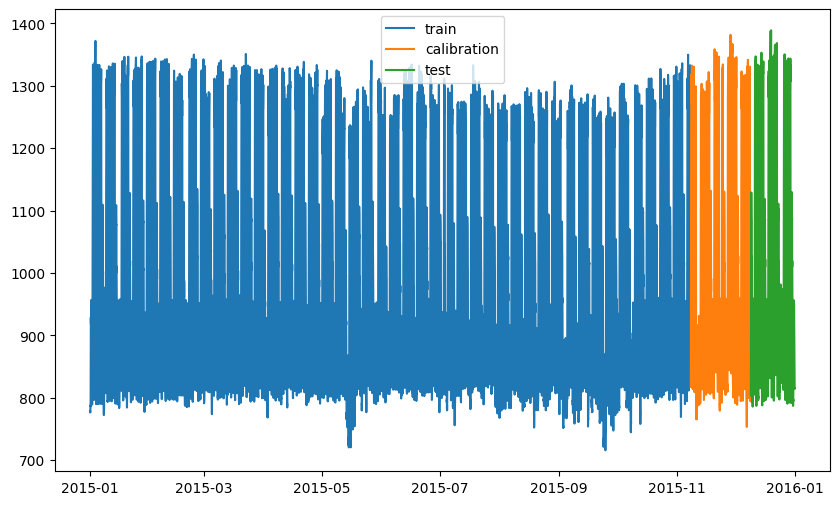

In [24]:
# Create NeuralProphet object
m = NeuralProphet()
# Data spliting function split one time-series dataframe into two
# Configure the hourly frequency by assigning 'H' to parameter freq
# Configure the splitting ratio with a value between 0 and 1 for valid_p
df['ds'] = pd.to_datetime(df['ds'])
df_train, df_test = m.split_df(df, freq="H", valid_p=1.0 / 16)
df_train, df_cal = m.split_df(df_train, freq="H", valid_p=1.0 / 11)
df_train.shape, df_cal.shape, df_test.shape

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df_train.ds, df_train.y, label="train")
ax.plot(df_cal.ds, df_cal.y, label="calibration")
ax.plot(df_test.ds, df_test.y, label="test")
ax.legend()
plt.show()

In [27]:
# base model
# Parameter for autoregression
confidence_lv = 0.9
quantile_list = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)]
# Predict the value in the next hours based on the last three daysin an-hour steps
n_lags = 3 * 24
# Create a simple quantile regression model
cp_model1 = NeuralProphet(quantiles=quantile_list)
cp_model1.set_plotting_backend("plotly-static")

# Create a 4-layer autoregression model as the base
cp_model2 = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
    quantiles=quantile_list,
)
cp_model2.set_plotting_backend("plotly-static")

# Feed the training subset in the configured NeuralProphet models
# Configure the hourly frequency by assigning 'H' to parameter freq
set_random_seed(0)
metrics1 = cp_model1.fit(train_df, freq="H")
set_random_seed(0)
metrics2 = cp_model2.fit(train_df, freq="H")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.
Finding best initial lr: 100%|██████████| 246/246 [00:01<00:00, 161.24it/s]


Epoch 60: 100%|██████████| 60/60 [00:00<00:00, 88.78it/s, loss=0.0299, v_num=2, MAE=64.50, RMSE=81.40, Loss=0.0289, RegLoss=0.000]   

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60



Epoch 60: 100%|██████████| 60/60 [00:01<00:00, 48.09it/s, loss=0.000887, v_num=3, MAE=8.500, RMSE=11.90, Loss=0.000795, RegLoss=0.000]    


In [29]:
# Parameter for Conformalized Quantile Regression
method = "cqr"
alpha = 1 - confidence_lv

# Enable conformal predict on the pre-trained models
# Evaluate parameter is optional, refer to the "Evaluate Performance" session below
cqr_forecast1 = cp_model1.conformal_predict(
    df_test, calibration_df=df_cal, alpha=alpha, method=method, plotting_backend="plotly-static"
)
cqr_forecast2 = cp_model2.conformal_predict(
    df_test, calibration_df=df_cal, alpha=alpha, method=method, plotting_backend="plotly-static"
)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.12it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.86it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.36it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


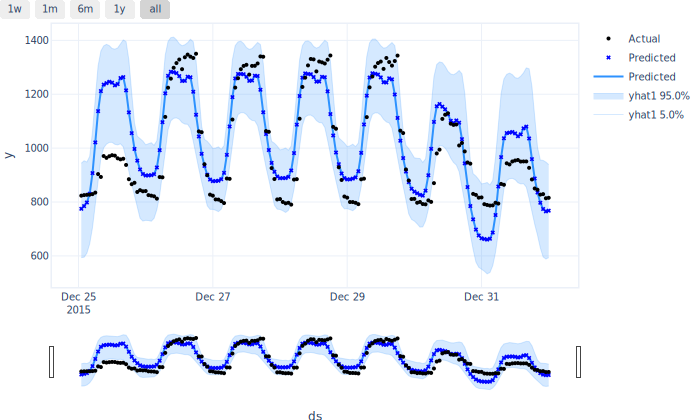

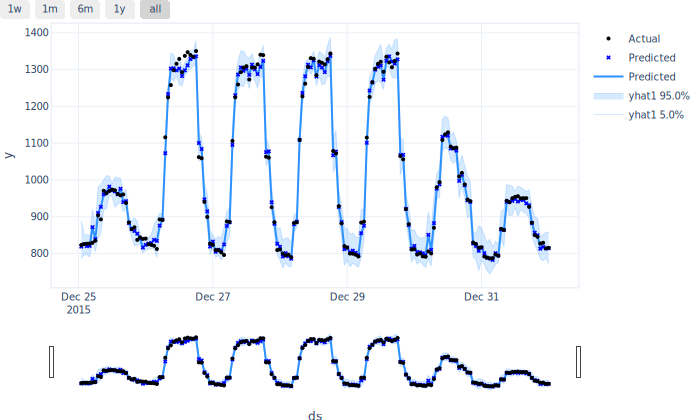

In [31]:
# Date range shown in the plots (optional)
cutoff = 7 * 24
# Plot the forecast with the confidence interval
fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], plotting_backend="plotly-static"
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], plotting_backend="plotly-static"
)

In [33]:
# evaluate the performance
# Create evaluation dataframe skeleton with the 2 models (denoted as m1 and m2)
models = ["m1", "m2"]
eval_df = pd.DataFrame(models, columns=pd.MultiIndex.from_tuples([("model", "", "")]))

# Extract the cqr performance metrics from their respective forecast datasets
cqr_eval1 = uncertainty_evaluate(cqr_forecast1)
cqr_eval2 = uncertainty_evaluate(cqr_forecast2)

# Aggregate the cqr performance metrics for m1 and m2
cqr_evals = [cqr_eval1, cqr_eval2]
cqr_eval_df = pd.concat(cqr_evals).reset_index(drop=True)

# Concatenate the naive and cqr evaluation dataframes
eval_df = pd.concat([cqr_eval_df], axis=1, keys=["cqr"])
eval_df

cqr                 
           yhat1                 
  interval_width miscoverage_rate
0     308.337280         0.102377
1      76.197144         0.025263